<a href="https://colab.research.google.com/github/feodosiya/Classical_ML_hw/blob/main/AI_HW3_Classification_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание 3. Линейная классификация. Работа с признаками**

### **Оценивание и штрафы**

Как всегда - каждая из задач имеет «стоимость» (указана в скобках около задачи).

В задании три части:

- Часть 1 (2.5 балла): написание логистической регрессии своими руками
- Часть 2 (5 баллов): различные методы отбора признаков
- Часть 3 (3.5 балла): обучение моделей классификации на текстах

Всего за задание можно получить 11 баллов, но:

**Балл за задание = min{ваш балл, 10}.**

In [3]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Populating the interactive namespace from numpy and matplotlib


# **Часть 1. Логистическая регрессия своими руками (2.5 балла)**

## **Задание 1. Реализуйте класс логистической регрессии, обучаемой с помощью:**

**Задание 1.1 (1 балл). Градиентного спуска**

**Задание 1.2 (1 балл). Стохастического градиентного спуска**

До этого вы писали код без ограничений. Здесь же необходимо соблюдать следующие условия:

- Градиентный спуск необходимо записать в векторном виде;
- Циклы средствами python допускается использовать только для итераций градиентного спуска;

**Класс градиентного спуска должен:**
- В качестве критерия останова использовать (одновременно):
  - проверку на евклидову норму разности весов на двух соседних итерациях задаваемого параметром `tolerance`;
  - достижение максимального числа итераций, задаваемого параметром `max_iter`.
- Обладать атрибутом `loss_history`. В нём после вызова метода fit должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту). Данный атрибут необходим, чтобы проследить, что оптимизационный процесс действительно сходится;
- Инициализировать веса случайным образом или нулевым вектором (на ваш выбор).

Полезно [почитать](https://scikit-learn.org/stable/developers/develop.html).

**Шаблон класса описан ниже, вам нужно реализовать каждую из заготовленных функций.**

**ВАЖНО!** Мы заполняем данный шаблон, даже если он нам не нравится. Менять структуру класса и писать по-своему запрещено - за это будут сняты баллы.

In [4]:
import numpy as np
from sklearn.base import BaseEstimator

class LogReg(BaseEstimator):
    def __init__(self, gd_type='stochastic',
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) — init weights
        eta: learning rate
        """
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration

    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) if self.w0 is None else self.w0

        for iteration in range(self.max_iter):
            if self.gd_type == 'stochastic':
                idx = np.random.randint(n_samples)
                X_batch = X[idx:idx + 1]
                y_batch = y[idx:idx + 1]
            else:
                X_batch = X
                y_batch = y

            grad = self.calc_gradient(X_batch, y_batch)
            self.w -= self.eta * grad

            loss = self.calc_loss(X, y)
            self.loss_history.append(loss)

            if np.linalg.norm(grad) < self.tolerance:
                break

        return self


    def predict_proba(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        else:
          return 1 / (1 + np.exp(-X.dot(self.w)))
        pass


    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        else:
          return (self.predict_proba(X) >= 0.5).astype(int)
        pass

    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        linear_preds = X.dot(self.w)
        probs = 1 / (1 + np.exp(-linear_preds))
        return X.T.dot(probs - y) / X.shape[0]

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float
        """
        linear_preds = X.dot(self.w)
        probs = 1 / (1 + np.exp(-linear_preds))
        return -np.mean(y * np.log(probs+1e-15) + (1-y) * np.log(1-probs+1e-15))


Теперь проверим работу вашего класса на синтетических данных.

In [5]:
%pylab inline
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Populating the interactive namespace from numpy and matplotlib


In [6]:
X, y = make_classification(
    n_samples=100000, n_features=20, n_informative=10, n_redundant=10,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

```Дальше тест - сравню с пакетным методом```

In [7]:
from sklearn.metrics import accuracy_score, log_loss

my_model = LogReg(gd_type='full', tolerance=1e-4, max_iter=1000, eta=0.1)
my_model.fit(X_train, y_train)

sk_model = LogisticRegression(solver='saga', max_iter=1000)  # сравниваю с вариацией SGD
sk_model.fit(X_train, y_train)

y_pred_my = my_model.predict(X_test)
y_pred_sk = sk_model.predict(X_test)

print("Accuracy (кастом):", accuracy_score(y_test, y_pred_my))
print("Accuracy (пакет):", accuracy_score(y_test, y_pred_sk))
print("Log Loss (кастом):", log_loss(y_test, my_model.predict_proba(X_test)))
print("Log Loss (пакет):", log_loss(y_test, sk_model.predict_proba(X_test)[:, 1]))

print("Loss History (кастом):", my_model.loss_history)

Accuracy (кастом): 0.8488666666666667
Accuracy (пакет): 0.8486666666666667
Log Loss (кастом): 0.3481963902665826
Log Loss (пакет): 0.34792822980022975
Loss History (кастом): [0.43246012055294125, 0.4043380781008335, 0.39139344920488317, 0.3828543973223415, 0.37677896783984405, 0.3722581039768154, 0.3687828243607738, 0.3660425490836256, 0.3638366293109532, 0.3620298250332917, 0.36052788388374546, 0.35926329545476615, 0.3581865787393211, 0.3572607460841497, 0.3564576715694691, 0.35575564302511065, 0.3551376726435181, 0.3545903069166089, 0.3541027730232719, 0.3536663566674085, 0.35327394209734, 0.35291966765590616, 0.35259866485430225, 0.3523068586384137, 0.3520408130289558, 0.35179761077475713, 0.3515747587575057, 0.35137011307106575, 0.35118181925872327, 0.3510082643192089, 0.3508480379160023, 0.3506999008321596, 0.35056275916546875, 0.3504356430986362, 0.35031768933649465, 0.3502081264984081, 0.3501062629046709, 0.35001147631205487, 0.3499232052440981, 0.3498409416323992, 0.34976422454

In [8]:
sk_model.predict_proba(X_test)[:, 1]

array([0.56219954, 0.87007752, 0.97389614, ..., 0.52363667, 0.65349536,
       0.7620046 ])

**Важно:** далее предполагается, что вы используете собственную реализацию логистической регрессии.
Если с написанием класса возникли проблемы, используйте реализацию sklearn, чтобы не терять баллы за остальные задания.

## **Задание 2 (0.5 балла)**

Обучите логистическую регрессию на синтетических данных.

На тестовой части посчитайте ROC-AUC, PR-AUC. Постройте ROC и PR кривые. Проинтерпретируйте результат.

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

# в тесте выше обучила регрессию, беру тот результат

precision, recall, _ = precision_recall_curve(y_test, my_model.predict_proba(X_test))

print("ROC-AUC (кастом):", roc_auc_score(y_test, my_model.predict_proba(X_test)))
print("PR-AUC (кастом):", auc(recall, precision))

ROC-AUC (кастом): 0.9258430929663389
PR-AUC (кастом): 0.9245921740897283


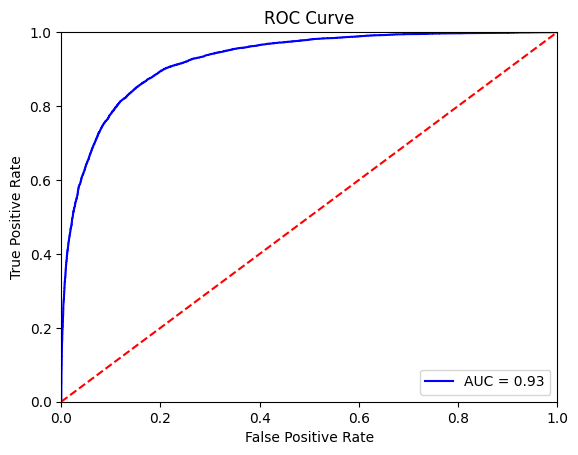

In [7]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_test, my_model.predict_proba(X_test))
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

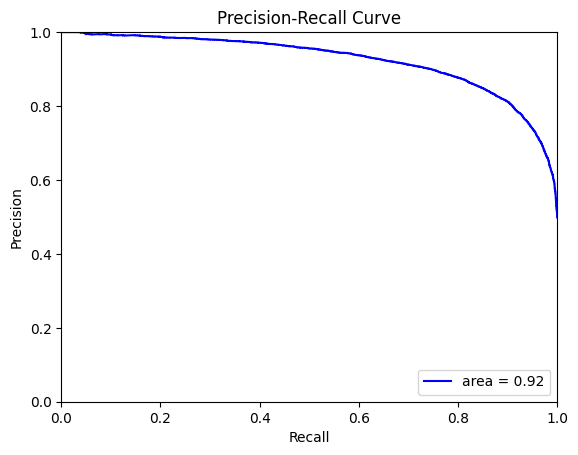

In [8]:
plt.plot(recall, precision, color='b', label='area = %0.2f' % auc(recall, precision))
plt.title('Precision-Recall Curve')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# **Часть 2. Отбор признаков (5 баллов)**

Перейдём к еще одной важной части процесса работы с данными — отбору признаков. Он нужен в следующих случаях:
- Мы хотим сократить время вычислений;
- Мы хотим избежать переобучения;
- Мы хотим попытаться улучшить качество модели за счет уменьшения признакового пространства;

В этой части мы попробуем применить несколько подходов для отбора признаков и оценим, как они влияют на качество модели и сколько времени занимают.

**Данные** \

Будем использовать датасет [об обращениях клиентов по страховым случаям](https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data?select=train.csv). Скачайте его с Kaggle (файл `train.csv`).

Задача представляет собой бинарную классификациюю — воспользуется ли клиент страховкой на авто в ближайший год.

In [9]:
from google.colab import drive

drive.mount('/content/drive')

PATH_TO_DATASET = '/content/drive/MyDrive/ML Start/train.csv'

data = pd.read_csv(PATH_TO_DATASET, index_col=0)
target = data.target.values

data = data.drop('target', axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=124)

Mounted at /content/drive


### **Задание 3. (0.25 балла)**

Прежде всего — в данных много категориальных признаков.

- Закодируйте их с помощью one-hot кодирования. Категориальные признаки отмечены постфиксом `cat`;
- Исходные колонки с категориальными признаками удалите;
- Зафиксируйте, сколько признаков получилось;

In [11]:
X_train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
381341,1,1,8,0,0,0,0,1,0,0,...,2,1,5,8,0,1,1,0,0,0
1327969,2,2,2,1,0,0,0,0,1,0,...,6,0,2,5,0,1,1,0,1,0
601794,0,1,2,0,0,1,0,0,0,0,...,9,1,5,3,0,0,0,0,1,1
632925,6,1,11,1,0,0,1,0,0,0,...,8,1,2,4,0,1,0,0,1,1
74864,3,1,5,1,0,0,0,1,0,0,...,9,2,3,8,0,1,1,1,0,0


In [10]:
from sklearn.preprocessing import OneHotEncoder

cat_columns = [col for col in X_train.columns if col.endswith('cat')]

ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_train = ohe.fit_transform(X_train[cat_columns])

X_train_enс = pd.concat([pd.DataFrame(encoded_train,
                                    columns=ohe.get_feature_names_out(cat_columns),
                                    index=X_train.index),
                                    X_train.drop(columns=cat_columns)], axis=1)

In [11]:
encoded_test = ohe.transform(X_test[cat_columns])

X_test_enc = pd.concat([pd.DataFrame(encoded_test,
                                    columns=ohe.get_feature_names_out(cat_columns),
                                    index=X_test.index),
                                    X_test.drop(columns=cat_columns)], axis=1)

In [12]:
X_train_enс.shape[1] # ох

213

### **Задание 4 (1 балл)**

Обучим несколько моделей, перечисленных ниже. В качестве метрики будем использовать ROC-AUC.

**Задание 4.1**

- Обучите модель логистической регрессии. Замерьте скорость обучения модели
- Обучите метод опорных векторов
- Обучите метод k ближайших соседей
- Посчитайте качество моделей (ROC-AUC) на тестовой выборке

**Задание 4.2**

Для каждой из трех моделей (логистическая регрессия, SVM, KNN) подберите при помощи GridSearchCV на тренировочных данных оптимальные гиперпараметры:
- Для логистической регрессии: C, class_weight
- Для SVM: C, kernel, class_weight
- Для KNN: n_neighbors, weights

Затем посчитайте качество моделей на тестовой выборке.

В заданиях 4.1 и 4.2 замеряйте время обучения моделей.


In [15]:
# Логистическая регрессия
%%time

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_enс, y_train)

CPU times: user 2min 1s, sys: 11.6 s, total: 2min 13s
Wall time: 1min 23s


LogisticRegression(max_iter=1000)

In [9]:
from sklearnex import patch_sklearn
import warnings
warnings.filterwarnings("ignore")

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
# SVM

%%time
from sklearn.svm import SVC

sv = SVC(kernel='linear', probability=True)
sv.fit(X_train_enс[:20000], y_train[:20000]) # договорились обучать на срезе из 20к объектов

CPU times: user 22.1 s, sys: 883 ms, total: 23 s
Wall time: 16 s


SVC(kernel='linear', probability=True)

In [18]:
from sklearnex import unpatch_sklearn
unpatch_sklearn()  # много ворнингов выдает, методы ломаются

In [19]:
# KNN
%%time
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_enс, y_train)

CPU times: user 690 ms, sys: 486 ms, total: 1.18 s
Wall time: 1.11 s


KNeighborsClassifier()

In [20]:
print("ROC-AUC (LogReg):", roc_auc_score(y_test, lr.predict_proba(X_test_enc)[:, 1]))
print("ROC-AUC (SVM):", roc_auc_score(y_test, sv.predict_proba(X_test_enc)[:, 1])) # так долго (если не ускорять), и так плохо
print("ROC-AUC (KNN):", roc_auc_score(y_test, knn.predict_proba(X_test_enc)[:, 1]))

ROC-AUC (LogReg): 0.6381060064255387
ROC-AUC (SVM): 0.5172101939748044
ROC-AUC (KNN): 0.5091952843544416


In [18]:
# LR
from sklearn.model_selection import GridSearchCV

params = {'C': np.arange(1, 11),
          'class_weight': [
            None,
            'balanced']}

gs_lr = GridSearchCV(LogisticRegression(max_iter=1000), params, cv=3, scoring='roc_auc')

gs_lr.fit(X_train_enс[:20000], y_train[:20000])

print(gs_lr.best_score_)
print(gs_lr.best_params_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.5638538814775532
{'C': 1, 'class_weight': None}


In [11]:
# SVC #1

%%time

#from sklearn.svm import SVC

patch_sklearn()
params = {'kernel' : ['rbf','poly','sigmoid','linear']}

gs_svc = GridSearchCV(SVC(), params, cv=3, scoring='roc_auc')

gs_svc.fit(X_train_enс[:20000], y_train[:20000])

print(gs_svc.best_score_)
print(gs_svc.best_params_)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


0.5401533982718228
{'kernel': 'poly'}
CPU times: user 1min 28s, sys: 3.72 s, total: 1min 32s
Wall time: 1min 8s


In [13]:
# SVC #2
%%time
#from sklearnex import unpatch_sklearn

params = {'C': np.arange(1, 11),
          'class_weight': [
            None,
            'balanced']}

gs_svc2 = GridSearchCV(SVC(gs_svc.best_params_), params, cv=3, scoring='roc_auc')

gs_svc2.fit(X_train_enс[:20000], y_train[:20000])

print(gs_svc2.best_score_)
print(gs_svc2.best_params_)
unpatch_sklearn()

0.5748695086421516
{'C': 1, 'class_weight': 'balanced'}
CPU times: user 12min 22s, sys: 20.2 s, total: 12min 42s
Wall time: 8min 9s


In [15]:
# KNN
%%time
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance']
}

gs_knn = GridSearchCV(KNeighborsClassifier(), params, cv=3, scoring='roc_auc')

gs_knn.fit(X_train_enс[:20000], y_train[:20000])

print(gs_knn.best_score_)
print(gs_knn.best_params_)

0.5176331195164586
{'n_neighbors': 24, 'weights': 'uniform'}
CPU times: user 6min 4s, sys: 344 ms, total: 6min 4s
Wall time: 6min 7s


### **Встроенные методы**

**Заметим, что:**

- Время обучения моделей отличается между собой.
- Несмотря на то, что признаков много, качество модели не очень хорошее.


Попробуем решить проблемы — улучшить качество и при этом сократить пространство признаков и, соответственно, время обучения моделей.



**Отбор признаков встроенным методом.**

Начнём с отбора признаков с помощью линейной модели. Делая это, мы используем факт:
> веса линейной модели отражают  вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков.

Такой метод отбора называются встроенным в модель методом, так как он заложен в особенности модели.

**Важно:** применение этого подхода требует машстабирования признаков (подумайте, почему). Вы можете использовать приведение к стандартному нормальному распределению (`StandardScaler`) с параметрами или MinMax преобразование (`MinMaxScaler`).

### **Задание 5 (0.75 балла)**

Оставьте 150 признаков с наибольшими по модулю весами после обучения логистической регрессии.

- Замерьте скорость такого отбора признаков. (0.2 балла)

- Обучите логистическую регрессию на исходных признаках. Из них оставьте 150 лучших (с наибольшими по модулю весами).
- Масштабируйте данные — все, кроме категориальных и бинарных признаков. Зафиксируйте, сколько признаков пришлось масштабировать. (0.25 балла)
- Обучите новую модель на 150 признаках и оцените её качество. (0.15 балла)




In [15]:
from sklearn.preprocessing import StandardScaler

num_features = [col for col in X_train_enс.columns
                            if 'cat' not in col and not col.endswith('bin')]

scaler = StandardScaler()
X_train_scaled = X_train_enс.copy()
X_test_scaled = X_test_enc.copy()

X_train_scaled[num_features] = scaler.fit_transform(X_train_enс[num_features])
X_test_scaled[num_features] = scaler.transform(X_test_enc[num_features])

len(num_features)

26

In [76]:
%%time

from sklearn.feature_selection import SelectFromModel

estimator = LogisticRegression()
selector = SelectFromModel(estimator)
selector = selector.fit(X_train_scaled, y_train)

coef = np.abs(selector.estimator_.coef_).flatten()
top_150_features = [X_train_scaled.columns[i] for i in np.argsort(coef)[-150:]]

CPU times: user 13.1 s, sys: 1.24 s, total: 14.4 s
Wall time: 7.92 s


ROC-AUC (LogReg upd): 0.6386263934306508


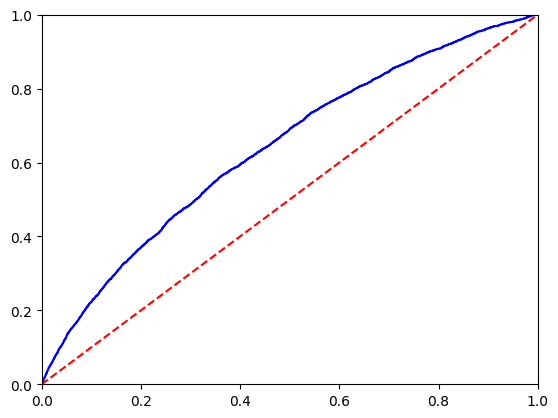

CPU times: user 12.6 s, sys: 2.84 s, total: 15.5 s
Wall time: 9.4 s


In [77]:
%%time
from sklearn.metrics import roc_curve

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled[top_150_features], y_train)
lr_pred = lr.predict_proba(X_test_scaled[top_150_features])[:, 1]

print("ROC-AUC (LogReg upd):", roc_auc_score(y_test, lr_pred))

fpr, tpr, threshold = roc_curve(y_test, lr_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show();

### **Бонус (0.25 балла)**

Попробуйте реализовать итеративный отбор признаков, а именно:

1) Сначала отобрать около 200 признаков (действуя как в задании выше)

2) Потом повторить процедуру для отбора 150 признаков из 200 (снова действуя как в задании выше)

In [79]:
top_200_features = [X_train_scaled.columns[i] for i in np.argsort(coef)[-200:]]

selector = selector.fit(X_train_scaled[top_200_features], y_train)
coef = np.abs(selector.estimator_.coef_).flatten()
top_150_features = [X_train_scaled.columns[i] for i in np.argsort(coef)[-150:]]

lr_2 = LogisticRegression(max_iter=1000)
lr_2.fit(X_train_scaled[top_150_features], y_train)
lr_pred_2 = lr_2.predict_proba(X_test_scaled[top_150_features])[:, 1]

print("ROC-AUC (LogReg upd 2):", roc_auc_score(y_test, lr_pred_2)) # все верно?? тогда стало хуже

ROC-AUC (LogReg upd 2): 0.6364858920337982


In [16]:
import gc
gc.collect()

31

### **Задание 6 (0.5 балла)**

Также можно задать отбор признаков, используя другия свойства модели. Вспомним, что L1-регуляризация тоже умеет отбирать признаки.

- Обучите модель на исходных данных. Подберите по сетке (GridSearch) наилучшее значение коэффициента регуляризации C. (0.1 балла)

- Посмотрите сколько признаков отобрала модель с найденным оптимальным C?
  - Сначала посчитайте только число ненулевых весов
  - Затем посчитайте число весов, которые после округления до двух знаков после запятой не равны нулю (0.25 балла)

Удалось ли отобрать 150 признаков за 1 шаг? (0.05 балла)

In [91]:
from sklearn.model_selection import GridSearchCV

params = {'C': np.arange(1, 25)}

gs_lr = GridSearchCV(LogisticRegression(max_iter=10000), params, cv=3, scoring='roc_auc')

gs_lr.fit(X_train_scaled[:20000], y_train[:20000]) # на полной выборке вылетает, к сожалению

print(f"Лучший C: {gs_lr.best_params_['C']}")
print(f"Количество ненулевых весов: {np.sum(gs_lr.best_estimator_.coef_ != 0)}")
print(f"Количество ненулевых весов с округлением: "
      f"{np.sum(np.round(gs_lr.best_estimator_.coef_, 2) != 0)}")

# с первой попытки отобрать 150 не вышло

Лучший C: 1
Количество ненулевых весов: 213
Количество ненулевых весов с округлением: 207


### **Методы фильтрации**

Также можно отбирать признаки, применяя методы математической статистики. А именно, в нашем случае, через подсчёт некоторой функции для каждого признака. На основании значений этой функции (она называется *статистикой*) мы можем оставлять наиболее важные признаки. Методы этого семейства называют *фильтрационными* или *filter methods*.

**Что проверяем:**

Равны ли математические ожидания (то есть выборочные средние) распределений признака для двух разных классов? Если они различаются, значит и сами распределения разные. И можно сделать вывод, что по этому признаку модель сможет отличить один класс от другого. А если распределения неотличимы и значение статистики маленькое, то и признак бесполезен.


Для проверки будем считать t-статистику:

$$t(x) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ s^2_+ + n_- s^2_-}{n_+ + n_-}}},$$

где $\mu$, $s$, $n$ соответственно среднее, среднеквадратичное отклонение и количество объектов каждого из классов.

**Примечание:** Если у вас была данная тема на курсе по математической статистике, то вы без труда узнаете статистику гипотезы о разности средних при неизвестных дисперсиях.

Хотя мы и не используем статистическое тестирование явно, предпосылки о том, что наблюдения независимы, одинаково распределены и $n$ велико, должны соблюдаться, иначе статистика не имеет смысла. Но у нас большая выборка, поэтому они выполняются.

Для отбора признаков по t-статистике мы возьмём признаки с наибольшим значением статистики.

### **Задание 7 (1 балла)**

-  Масштабируйте признаки исходного датасета — все, кроме категориальных и бинарных.
- Выделите непрерывные признаки (те, которые масштабировали)
- Посчитайте значения t-статистики. Оставьте ***половину*** признаков с наибольшим значением статистики, объедините их с категориальными и бинарными.
- Обучите модель логистической регрессии и замерьте качество.

Не забудьте замерить скорость отбора признаков в этом случаев.

```Вычитала, что функция f_classif для 2-х переменных вычисляет аналог t-статистики через тест ANOVA. Не помню этого в матриалах, но решила воспользоваться.```

In [30]:
%%time

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=X_train_scaled[num_features].shape[1] // 2 )
X_train_selected = selector.fit_transform(X_train_scaled[num_features],
                                          y_train)
# их всего 26, вряд ли будет большой эффект

f_features = [X_train_scaled.columns[i] for i in selector.get_support(indices=True)]

CPU times: user 395 ms, sys: 160 ms, total: 554 ms
Wall time: 613 ms


In [33]:
lr_K = LogisticRegression(max_iter=1000)
lr_K.fit(pd.concat([X_train_scaled.drop(columns=num_features),
                    X_train_scaled[f_features]], axis=1), y_train)
lr_pred_K = lr_K.predict_proba(pd.concat([X_test_scaled.drop(columns=num_features),
                    X_test_scaled[f_features]], axis=1))[:, 1]

print("ROC-AUC (LogReg upd 2):", roc_auc_score(y_test, lr_pred_K))

ROC-AUC (LogReg upd 2): 0.6273603384446689


### **Методы-обёртки**

### **Задание 8 (бонус, 1 балл)**


Заключительный из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди каждый из признаков и смотрим, как это влияет на качество модели, обученной без удаленного признака. Удаляем признаки таким жадным способом.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только на финальной оценке качества.

Сделайте одну итерацию и прикиньте, сколько времени займёт такой отбор признаков. Кажется, что чересчур много. Давайте возьмём маленький сэмпл данных (например, в 10 тысяч объектов), что сильно уменьшит время итерации. Теперь это долго, но уже приемлимо.

Если это всё ещё долго для вашего комьютера, можете попробовать брать не по одному признаку, а сразу по пять (и удалять сразу тоже по 5). Для этого перед каждой итерацией удаления делите заново все признаки на группы по 5 штук.

Снова оставьте только 150 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [59]:
from sklearn.feature_selection import RFE

%%time
X_train_part, X_val, y_train_part, y_val = train_test_split(X_train_scaled,
                                                  y_train, test_size=0.3, random_state=42)

# пакетная

rfe = RFE(LogisticRegression(max_iter=1000),
          n_features_to_select=150, step=1)
rfe.fit_transform(X_train_part[:10000], y_train_part[:10000])

CPU times: user 16.8 s, sys: 5.03 s, total: 21.8 s
Wall time: 13.8 s


array([[ 0.        ,  1.        ,  0.        , ...,  0.23346357,
         0.53015762,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -1.26508216,
        -0.15538797,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -2.01435503,
         0.53015762,  0.        ],
       ...,
       [ 1.        ,  0.        ,  0.        , ..., -0.51580929,
         1.90124882,  0.        ],
       [ 1.        ,  0.        ,  0.        , ..., -0.51580929,
        -0.15538797,  0.        ],
       [ 1.        ,  0.        ,  0.        , ...,  0.98273644,
        -1.52647917,  0.        ]])

In [63]:
lr_R = LogisticRegression(max_iter=1000)
lr_R.fit(X_train_scaled[X_train_scaled.columns[rfe.support_]], y_train)
lr_pred_R = lr_R.predict_proba(X_test_scaled[X_test_scaled.
                                             columns[rfe.support_]])[:, 1]

print("ROC-AUC (LogReg rfe):", roc_auc_score(y_test, lr_pred_R))

ROC-AUC (LogReg rfe): 0.6340777139852736


In [17]:
%%time

# кастомная
def greedy_selection(X, y, n_features=150):

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    remaining_ft = list(X.columns)

    while len(remaining_ft) > n_features:
        scores = {}

        for feature in remaining_ft:
            temp_features = [f for f in remaining_ft if f != feature]

            model = LogisticRegression(max_iter=1000)
            model.fit(X_train[temp_features], y_train)

            preds = model.predict_proba(X_val[temp_features])[:, 1]
            scores[feature] = roc_auc_score(y_val, preds)

        del_feature = max(scores, key=scores.get) # для удаления выбираем признак, без которого рок-аук самый высокий
        remaining_ft.remove(del_feature)

    return remaining_ft


# тест
selected_ft = greedy_selection(X_train_scaled[:10000], y_train[:10000],
                                       n_features=X_train_scaled.shape[1] - 1)


CPU times: user 37.1 s, sys: 14.2 s, total: 51.3 s
Wall time: 31.1 s


In [18]:
%%time

selected_ft = greedy_selection(X_train_scaled[:10000], y_train[:10000],
                                       n_features=150)
# с богом

CPU times: user 28min 32s, sys: 11min 20s, total: 39min 53s
Wall time: 24min 23s


In [21]:
lr_R = LogisticRegression(max_iter=1000)
lr_R.fit(X_train_scaled[selected_ft], y_train)

lr_pred_R = lr_R.predict_proba(X_test_scaled[selected_ft])[:, 1]
roc_auc_score(y_test, lr_pred_R)

# :(
# предполагаю, качество чуть упало из-за обрезанной выборки

0.6222203328702421

Опционально (это не оценивается) можете рассмотреть более интересные стратегии отбора, чем жадная. Например, генетические алгоритмы. Можно закодировать бинарным вектором, включаем мы или нет тот или иной признак в модель. А дальше генетическим алгоритмом оптимизировать этот вектор. Всё ещё не быстро, но точно быстрее жадного.


### **Задание 9 (0.25 балла)**

Подведите итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству? Если не делали бонус — сравните встроенный метод и метод фильтрации.

*В моем случае методы отработали с похожим результатом. Чуть лучше справлялись те, которые работали на полных данных - это было возможно для более быстрых методов (например, встроенного). Если не сокращать выборку, в некоторых случаях падает из-за нехватки ОЗУ.*

1. Встроенный метод удобный и быстрый - дает возможность поэкспериментировать с моделями и параметрами.

2. Для метода фильтрации, мне кажется, важно правильно подобрать фукнцию - предложенная в задании не обязательно подходит лучше всего. В целом тоже быстрый, но показал результат чуть хуже.

3. На оберточный были большие надежды, но выборку больше 10.000 объектов потянуть не вышло, а на 10 результат не сильно впечатлил. Скорее всего, метод крутой, если данных не очень много.

# **Часть 3. Обучение моделей на текстовых данных. (3.5 балла)**

 ### **Подготовка данных из реального мира.**

Загрузите данные с конкурса  [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv) (вам нужна только обучающая выборка, файл `train.csv`). Задача состоит в определении постов, сообщающих о чрезвычайной ситуации. В рамках домашнего задания, этот набор данных будет отличным полем для тренировки в обработке признаков.

In [50]:
from google.colab import drive
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/ML Start/train NLP.csv'
data = pd.read_csv(PATH)

data.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### **Задание 10. Базовая предобработка (0.5 баллов).**

- Выведите на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [51]:
pd.isna(data).sum()

,0
id,0
keyword,61
location,2533
text,0
target,0


In [52]:
data.fillna('', inplace=True)

- Проанализируйте количество уникальных значений в числовых столбцах. Сделайте выводы.

In [53]:
pd.concat([data.select_dtypes(include='number').nunique(), pd.notna(data.select_dtypes(include='number')).sum()], axis=1)

,0,1
id,7613,7613
target,2,7613


- Проанализируйте соотношение классов в целевой переменной. Почему значимо это учитывать?

In [54]:
data.target.value_counts() # есть дисбаланс, стоит учитывать при выборе модели

,count
target,
0,4342
1,3271


- Объедините все три текстовых столбца в один (вам поможет конкатенация строк)

In [56]:
data['full_text'] = data['keyword'] + " " + data['location'] + " " + data['text']
data.drop(['keyword', 'location', 'text'], axis=1, inplace=True)

- Наконец, поделите данные на тренировочную и тестовую выборки.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('target', axis=1),
                                                    data.target,
                                                    test_size=0.25,
                                                    random_state=42)

### **Задание 11. Базовые модели. (1 балл).**

Данные, собираемые с сайтов, часто содержат мусор не информативный для моделей. Посмотрите, какого качества данные здесь. Для этого:
- Примените CountVectorizer из sklearn к сырым даным. Какого размера получилась матрица?

In [63]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

X_train['texts_tokenized'] = X_train['full_text'].apply(
    lambda x: ' '.join([w for w in word_tokenize(x) if w.isalpha()]))

cnt_vec = CountVectorizer()
X_cnt = cnt_vec.fit_transform(X_train['texts_tokenized'])
X_cnt.shape

(5709, 13935)

In [69]:
pd.DataFrame(X_cnt.toarray(), columns=cnt_vec.get_feature_names_out()).head()

,aa,aaaa,aaaaaaallll,aaarrrgghhh,aan,aannnnd,aar,aarhus,aaronthefm,ab,...,zzzz,åá,åç,åè,åê,åêfedex,åêi,ìït,ìñ,ìü
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
X_test['texts_tokenized'] = X_test['full_text'].apply(
    lambda x: ' '.join([w for w in word_tokenize(x) if w.isalpha()]))

X_test_cnt = cnt_vec.transform(X_test['texts_tokenized'])

- Обучите логистическую регрессию на полученном наборе. Какое качество `f1` у модели получилось на тестовых данных?

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lr = LogisticRegression(max_iter=1000)
lr.fit(X_cnt, y_train)
prediction = lr.predict(X_test_cnt)

print("f1-score (LogReg):", f1_score(y_test, prediction, average='weighted'))

f1-score (LogReg): 0.7998183277825253


- Обучите SVC на тех же данных с гиперпараметрами по умолчанию. Измерьте качество (`f1`) на тестовых данных и опишите результат. Проанализируйте качество и скорость обучения.

In [77]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_cnt, y_train)
prediction_svm = svm.predict(X_test_cnt)

print("f1-score (SVM):", f1_score(y_test, prediction_svm, average='weighted'))

f1-score (SVM): 0.8061285848813435


```Качество у SVM чуть выше, модель обучалась несущественно дольше. Скорее всего, если хорошо предобработать эти данные, SVM покажет очень хороший результат. ```

### **Задание 12. Улучшение базовых моделей за счет данных. (0.5 балла).**

- Подберите гиперпараметры CountVectorizer так, чтобы признаков было минимум в 4 раза меньше, чем объектов, а качество модели при этом изменилось не более чем на $\pm 0.07$. Опишите подобранные гиперпараметры и на что они влияют (0.5 балла).

Обучайте и логистическую регрессию, и SVC.

In [89]:
X_cnt.shape[0] // 4

1427

In [91]:
cnt_vec = CountVectorizer(
    min_df=0.005,
    max_df=0.9,
    max_features=X_cnt.shape[0] // 4,
    ngram_range=(1, 2))

X_cnt_tuned = cnt_vec.fit_transform(X_train['texts_tokenized'])
X_test_cnt_tuned = cnt_vec.transform(X_test['texts_tokenized'])
X_cnt_tuned.shape

(5709, 477)

In [92]:
svm = SVC()
svm.fit(X_cnt_tuned, y_train)
prediction_svm = svm.predict(X_test_cnt_tuned)

print("f1-score (SVM):", f1_score(y_test, prediction_svm, average='weighted'))

f1-score (SVM): 0.7744078640426826


In [93]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_cnt_tuned, y_train)
prediction = lr.predict(X_test_cnt_tuned)

print("f1-score (LogReg):", f1_score(y_test, prediction, average='weighted'))

f1-score (LogReg): 0.763005217606091


*   min_df позволяет игнорировать редкие n-граммы по порогу снизу
*   max_df - частые по порогу встречаемости сверху
*   max_features - прямое ограничение на количество признаков
*   ngram_range регулирует n в n-граммах

```Еще пробовала вариант с min_df=0.001, тогда пространство признаков уменьшается до ~160, но и качество снижается на 0.07. Выбрала сохранить в качестве.```

### **Задание 13. Улучшение базовых моделей путем подбора гиперпараметров. (1 балл).**
- Попробуйте подбирать разные гиперпараметры для логистической регрессии. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': [0.01, 0.1, 0.5, 1, 5, 10],
    'solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],
    'tol': [1e-4, 1e-3, 1e-2]
    }

gs = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                  param_grid=param_grid,
                  cv=5,
                  n_jobs=-1,
                  verbose=1,
                  scoring='f1_weighted')

gs.fit(X_cnt, y_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
630 fits failed out of a total of 1440.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "

NameError: name 'grid_search' is not defined

In [98]:
print(gs.best_params_)
best_model = gs.best_estimator_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.0001}


- Попробуйте подбирать разные гиперпараметры для модели SVC. Опишите подбираемые гиперапарметры и ваши результаты (0.5 балла)

In [100]:
best_model.fit(X_cnt_tuned, y_train)
prediction = best_model.predict(X_test_cnt_tuned)

print("f1-score (LogReg gs):", f1_score(y_test, prediction, average='weighted'))

f1-score (LogReg gs): 0.765667291683439


Подбор гиперпараметров помог немного улучшить качество логистической регресси, хотя SVM все еще справляется с этой задачей лучше.

Мы уменьшили силу регуляризации (C), ее тип по умолчанию (L2) остался лучшим по версии GS. Алгоритм оптимизации после подбора изменился на liblinear - алгоритм, основанный на методе градиентного спуска.   

### **Задание 14. (0.5 балла)**

Оформите два пайплайна:
- для модели регрессии
- для SVC модели

в пайплайн должны входить предобработка сырого датасета и обучение модели.

In [114]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer


preprocessor = Pipeline([
    ('text_preprocessing', ColumnTransformer([
        ('text', Pipeline([
            ('tokenize', FunctionTransformer(lambda x: x.apply(lambda text: ' '.join([w for w in word_tokenize(text)
                if w.isalpha()])), validate=False)),
            ('vectorize', CountVectorizer(min_df=0.005, max_df=0.9, max_features=1000, ngram_range=(1, 2)))
        ]), 'full_text')
    ], remainder='passthrough'))
])

logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                               param_grid={'penalty': ['l1', 'l2', 'elasticnet', None],
                                          'C': [0.01, 0.1, 0.5, 1, 5, 10],
                                          'solver': ['lbfgs', 'liblinear', 'saga', 'newton-cg'],
                                          'tol': [1e-4, 1e-3, 1e-2]},
                               cv=5, n_jobs=-1, verbose=1, scoring='f1_weighted'))])

# обучение через logreg_pipeline.fit(X_train[['full_text']], y_train) запустилось
# прервала, gs очень долго подбирает

In [120]:
from sklearn.model_selection import cross_validate


svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC())
])

svm_pipeline.fit(X_train[['full_text']], y_train)
prediction_svm = svm_pipeline.predict(X_test[['full_text']])

print("f1-score (SVM):", f1_score(y_test, prediction_svm, average='weighted'))

f1-score (SVM): 0.7744078640426826


In [122]:
cv_res = cross_validate(svm_pipeline, X_train[['full_text']], y_train, cv=5, scoring='f1_weighted', return_train_score=True)
cv_res['test_score'].mean()

0.764485103331038

### **Выводы**

Зафиксируйте выводы работы. Проанализируйте, что проделано и какие результаты вы получили. Заполняется в свободной форме.



1.   Написан класс для логистической регрессии. Работает с очень близкими к пакетной реализации, но не идентичными с ней результатами.
2. Подгружен и обработан объемный датасет с Kaggle, закодированы категориальные переменные. В датасете очень много признаков, смысл которых умом понять сложно (или невозможно), видимо, специально, чтобы пользовались изученными методами отбора признаков.
3. Обучены модели для задачи классификации с параметрами по умолчанию: LogReg, SVM, KNN. SVM работает ужасающе долго, пришлось искать возможности для ускорения. Подобраны более оптимальные параметры с помощью GridSearch.
4. Данные отмасштабированы, затем встроенным методом отобраны 150 (/200) наиболее важных признаков. Качество немного улучшилось.
5. Также отбор признаков попробовала осуществить итеративным подходом, через регуляризацию и методом фильтрации (считалась t-статистика). Отдельно опробован метод-обертка. Лучший результат дал встроенный метод.
6. Обработан второй датасет - текстовый: заполнены пропуски, тексты объединены в единый массив, удалены знаки препинания.
7. Опробованы модели логистической регрессии и SVM на сырых данных для классификации, результат ~0.8.
8. Сокращено пространство признаков с помощью CountVectorizer - с 13.935 до 477 с помощью настройки гиперпараметров (основную роль сыграла чистка редких n-грамм - параметр min_df). Качество упало до ~0.77.
9. Перебором по сетке подобраны параметры для логистической регрессии (изменился алгоритм оптимизации и C), ее результат приблизился к SVM.
10. Оформлен пайплайн для предобработки и обучения обеих моделей.




## Чей кот?

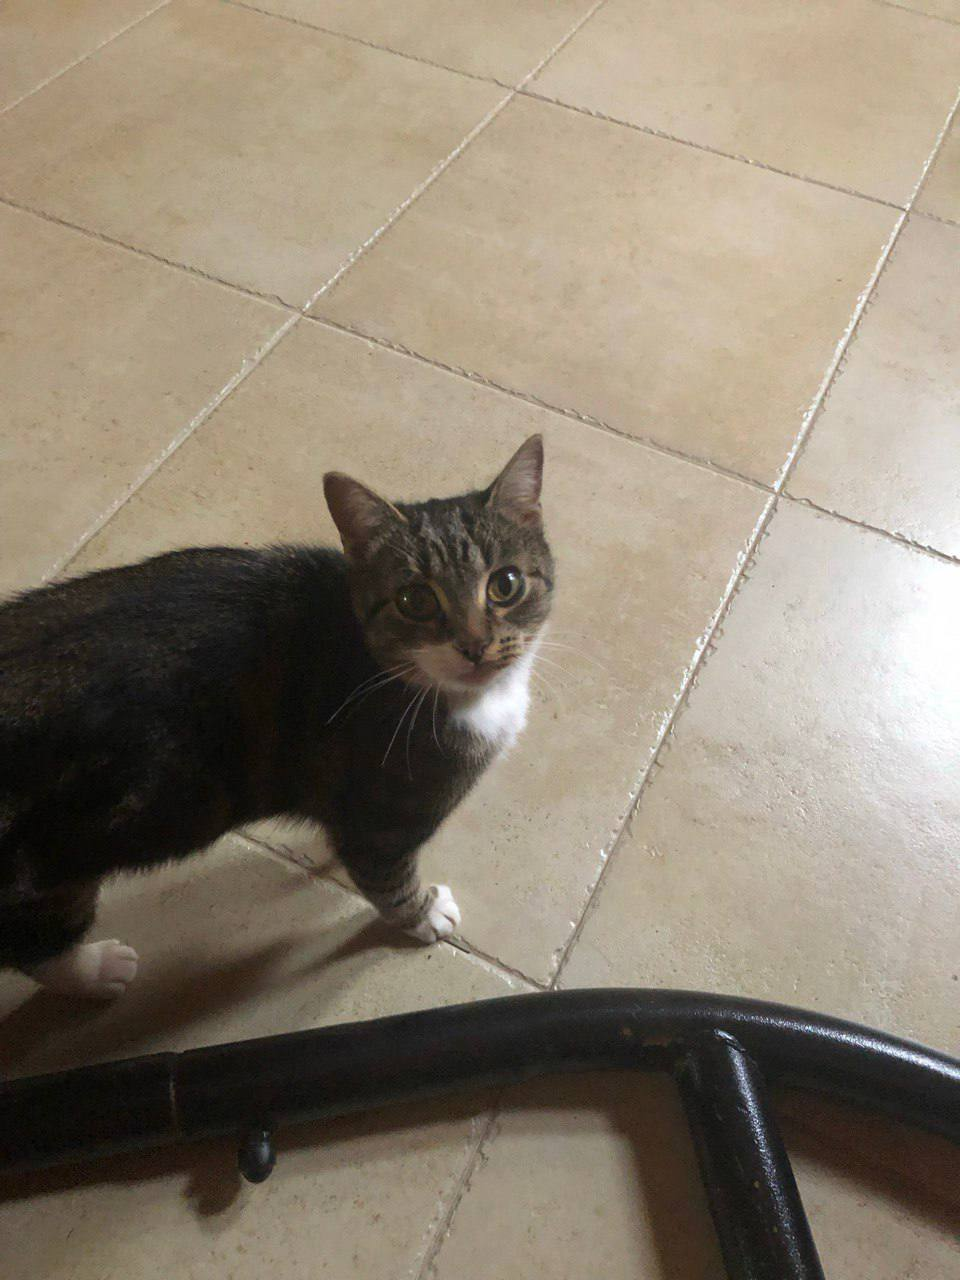

Сабрины